In [2]:
# Get basemap URL

import contextily as ctx
import geopandas as gpd
import rasterio
import rasterio.plot as rpl
from shapely.geometry import box
import matplotlib.pyplot as plt
import os


In [3]:

# Lon-Lat
top_left = [-117.12353,36.471]
bottom_right = [-116.57172,35.921]

west = top_left[0]
north = top_left[1]
east = bottom_right[0]
south = bottom_right[1]

if os.path.exists("south_dv.tif"):
    os.remove("south_dv.tif")
    
img, ext = ctx.bounds2raster(west,
    south,
    east,
    north,
    "south_dv.tif",
    zoom=12,
    source=ctx.providers.Stamen.TerrainBackground,
    ll=True
)



In [4]:
from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3857)

top_left = [-117.12353,36.471]
bottom_right = [-116.57172,35.921]

top_left_3857 = transformer.transform(top_left[1], top_left[0])
bottom_right_3857 = transformer.transform(bottom_right[1], bottom_right[0])



In [5]:
west = -125.19812
east = -113.29056
north = 44.52203
south = 34.15638

img, ext = ctx.bounds2raster(west,
    south,
    east,
    north,
    "overview_basemap.tif",
    zoom=5,
    source=ctx.providers.Stamen.TerrainBackground,
    ll=True
)



In [6]:
import numpy as np

def hillshade(array,azimuth,angle_altitude):
    azimuth = 360.0 - azimuth 

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.

    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)

    return 255*(shaded + 1)/2

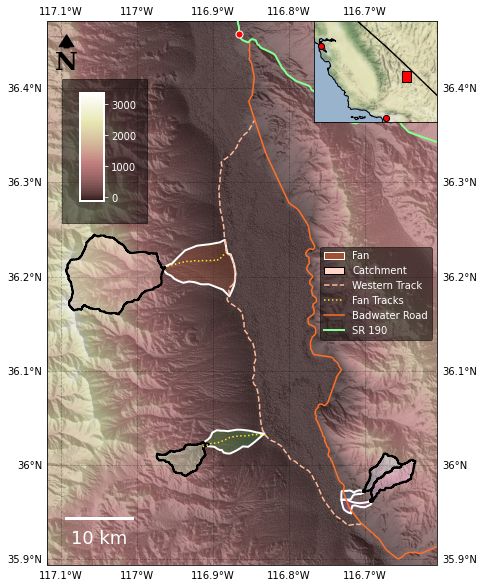

In [161]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import cartopy.crs as ccrs
import cartopy.feature
from matplotlib.colors import to_rgba
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
import matplotlib.patches as mpatches
import matplotlib.lines as mlines  

fan_alphas = [.3,.3,.3,.3]
catchment_alphas = [.3,.3,.3,.3]

color_choices = {
    'HP':{
            'fan': '#a15033',
            'catchment': '#ffd6c7'
        },
    'GC':{
            'fan': '#49a34b',
            'catchment': '#c9ffcb'
        },
    'SO1':{
            'fan': '#30648c',
            'catchment': '#c4e6ff'
        },
    'SO2':{
            'fan': '#933e96',
            'catchment': '#fdccff'
        }
}

fontprops = fm.FontProperties(size=18)
northfontprops = fm.FontProperties(size=25, weight='bold', family='serif')

fig = plt.figure(figsize=(17,10), linewidth=2)
ax = plt.axes(projection=ccrs.epsg(3857))
# 3857
top_b = 4285972.161
bottom_b = 4365552.863
left_b = -13037510.293
right_b = -12980420.118

road_colors = ['#ffbb99','#ffe730','#ffe730','#ff7029','#85ff91']
road_styles = ['--', ':', ':', '-', '-']
road_widths = [1.5,1.5,1.5,1.5,2]
road_names = ['Western Track', 'Fan Tracks','Fan Tracks', 'Badwater Road', 'SR 190']

with rasterio.open("SRTM/south_dv_srtm_3857.tif") as r:
    # Use hillshade function on a DTM Geotiff
    


    cax = fig.add_axes([0.38, 0.63, 0.02, 0.15], zorder=100)

    fig.patches.extend([plt.Rectangle((0.365, 0.6),0.07, 0.2,
                                  fill=True, color='black', alpha=0.5, zorder=10,
                                  transform=fig.transFigure, figure=fig)])
    
    hillshade_raster = hillshade(r.read(1),225,45)
    
    dem_data = r.read(1)
    
    roads = gpd.read_file('GIS/roads.shp').to_crs(epsg=3857)
    roads.plot(ax=ax, color=road_colors,
               linestyle=road_styles, linewidth=road_widths, zorder=201)
    
    catchments = gpd.read_file('GIS/fan_catchments.shp').to_crs(epsg=3857)
    
    ax.imshow(hillshade_raster, extent=(r.bounds.left, r.bounds.right, r.bounds.bottom, r.bounds.top),
              transform=ccrs.epsg(3857), cmap='gray')
    elev_ax = ax.imshow(dem_data, transform=ccrs.epsg(3857), cmap = plt.cm.pink, alpha=0.7,  extent=(r.bounds.left, r.bounds.right, r.bounds.bottom, r.bounds.top))

    catchments_colours = [color_choices['SO2']['catchment'], color_choices['SO1']['catchment'], color_choices['GC']['catchment'], color_choices['HP']['catchment']]
    catchments['colours'] = catchments_colours
    catchments['alpha'] = catchment_alphas
    catchments['colours_rgba'] = catchments.apply(
        lambda row: to_rgba(row['colours'], alpha=row['alpha']), axis=1)
    
    catchments.plot(ax=ax, edgecolor=[0, 0, 0], color=catchments['colours_rgba'], linewidth=2, zorder=120)
    
    fan_areas = gpd.read_file('GIS/fan_areal_extent.shp').to_crs(epsg=3857)
    
    fan_colours = [color_choices['HP']['fan'], color_choices['GC']['fan'], color_choices['SO1']['fan'], color_choices['SO2']['fan']]
    fan_areas['colours'] = fan_colours
    fan_areas['alpha'] = fan_alphas
    fan_areas['colours_rgba'] = fan_areas.apply(
        lambda row: to_rgba(row['colours'], alpha=row['alpha']), axis=1)
    
    fa_plot = fan_areas.plot(ax=ax, edgecolor=[1, 1, 1], color=fan_areas['colours_rgba'], linewidth=2, zorder=100)

     # position [left, bottom, width, height]
    ax_overview = fig.add_axes([0.541, 0.74, 0.161, 0.14], frameon=True)
    rpl.show(rasterio.open("overview_basemap.tif"), ax=ax_overview)

    usa_states_and_provinces = gpd.read_file('GIS/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces_southwest.shp').to_crs(epsg=3857)
    usa_states_and_provinces.plot(ax=ax_overview, edgecolor=[0, 0, 0, 1], color=[0, 0, 0, 0])
        
    overview_west = -13678709.899
    overview_north = 4725105.935
    overview_east = -12786349.175
    overview_south = 3998191.998

    ax_overview.set_ylim([overview_south,overview_north])
    ax_overview.set_xlim([overview_west, overview_east])
    
    poly_coords = [(top_left_3857[0], top_left_3857[1]), (bottom_right_3857[0], top_left_3857[1]),
                (bottom_right_3857[0],bottom_right_3857[1]), (top_left_3857[0], bottom_right_3857[1])]
    
    aoi_poly = Polygon(poly_coords)
    aoi_poly_patch = PolygonPatch(aoi_poly, facecolor=[1, 0, 0], edgecolor=[0,0,0])
    ax_overview.add_patch(aoi_poly_patch)
    ax_overview.set_yticks([])
    ax_overview.set_xticks([])
    
    ax.set_ylim([top_b,bottom_b])
    ax.set_xlim([left_b,right_b])
    scalebar = AnchoredSizeBar(ax.transData,
                               1000*10, '10 km', 'lower left',
                               pad=0.5,
                               color='white',
                               frameon=False,
                               size_vertical=250,
                               borderpad=0.5, sep=10,
                               fontproperties=fontprops)
    
    
    ax.add_artist(scalebar)

    cbar = fig.colorbar(elev_ax, cax=cax, orientation='vertical')
    cax.tick_params(axis='both', colors='white')
    cbar.outline.set_edgecolor('white')
    cbar.outline.set_linewidth(2)
          
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='black', alpha=0.3, linestyle='--')    

    x, y, arrow_length = .05, 0.975, 0.05
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', xycoords=ax.transAxes, fontproperties=northfontprops)
    
    populated_places = gpd.read_file('GIS/ne_110m_populated_places/ne_110m_populated_places_3857.geojson')
    populated_places.plot(ax=ax_overview, color='red', markersize=38, marker='o', edgecolor='k')
    
    points_of_interest = gpd.read_file('GIS/dv_places_of_interest.shp').to_crs(epsg=3857)
    points_of_interest.plot(ax=ax, color='red', markersize=50, marker='o', edgecolor='white', zorder=210)

    # Fake Legend Stuff
    
    fan_patch = mpatches.Patch(facecolor='#a15033',
                           edgecolor=[1, 1, 1],
                           linestyle='-',
                           label='Fan')
    catchment_patch = mpatches.Patch(facecolor='#ffd6c7',
                           edgecolor=[0, 0, 0],
                           linestyle='-',
                           label='Catchment')
    handles = [fan_patch,catchment_patch]
    
    inc = 0
    for rdx, rd in roads.iterrows():
        if inc !=2:
            handles.append(mlines.Line2D(
                [],
                [],
                color=road_colors[inc],
                linewidth=road_widths[inc],
                linestyle=road_styles[inc],
                label=road_names[inc]))
        inc+=1
    
    legend = ax.legend(handles=handles, loc='center right', framealpha=0.5)
    frame = legend.get_frame()
    frame.set_facecolor('black')
    frame.set_edgecolor('black')
    for text in legend.get_texts():
        text.set_color("white")
        
    plt.savefig('figures/fig_1_study_area.pdf')
    plt.show()
